# Exploratory data analysis and figures for the presentation

In [47]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

from IPython.display import FileLink,Audio

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

os.chdir(r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier')
print(os.getcwd())


Using cuda
C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier


In [48]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

def RAVDESS_extractor(audio_dir):
    data_list = []
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    RAV_metadata_df = pd.DataFrame(columns = columns)
    
    # Map identifiers to their corresponding values
    emotion_dict = {
      "01": "neutral", "02": "neutral", "03": "happy", "04": "sad",
      "05": "angry", "06": "fear", "07": "disgust", "08": "surprised"
    }
    
    intensity_dict = {"01": "medium", "02": "high"}
    statement_dict = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}
    
    
    data_list = []
    for actor_folder in os.listdir(audio_dir):
      actor_path = os.path.join(audio_dir, actor_folder)
    
      if os.path.isdir(actor_path):  # Check if it's a folder
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    parts = file.split(".")[0].split("-") #first split the .wav extension then the '-'
    
                    # Extract metadata from the filename
                    modality = parts[0]  # Not used, as it’s audio-only for now
                    vocal_channel = "speech" if parts[1] == "01" else "song"
                    emotion = emotion_dict[parts[2]]
                    emotional_intensity = intensity_dict[parts[3]]
                    statement = statement_dict[parts[4]]
                    actor_id = int(parts[6])
                    gender = "male" if actor_id % 2 != 0 else "female"
                    file_path = os.path.join(actor_path, file)  # Full path to the file
                    
                    # Append to datalist (ignoring the repetition)
                    data_list.append({
                        'Filename': file,
                        'Filepath':file_path,
                        'Gender': gender,
                        'Emotion': emotion,
                        'Emotional Intensity': emotional_intensity
                    })
    
    df_addon = pd.DataFrame(data_list)
    RAV_metadata_df = pd.concat([RAV_metadata_df, df_addon], ignore_index=True)

    return RAV_metadata_df

def CREMA_extractor(audio_dir,crema_metadata_df):
    data_list = []
    emotion_map_dict = {'SAD':'sad',
                       'ANG':'angry',
                       'DIS':'disgust',
                       'FEA':'fear',
                       'HAP':'happy',
                       'NEU':'neutral'}
    intensity_dict = {'LO':'low',
                     'MD':'medium',
                     'HI':'high',
                     'XX':'unknown',
                     'X':'unknown'}

    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    crema_organized_df = pd.DataFrame(columns = columns)
    
    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        actor_id = int(parts[0])

        gender = crema_metadata_df.loc[crema_metadata_df['ActorID'] == actor_id]['Sex'].values[0].lower()
        emotion = emotion_map_dict[parts[2]]

        #debugging
        #print(file_name)
        intensity = intensity_dict[parts[3]]

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    crema_organized_df = pd.concat([crema_organized_df,df_addon],ignore_index=True)
    return crema_organized_df

def SAVEE_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    savee_metadata_df = pd.DataFrame(columns = columns)

    data_list = []
    
    emotion_map_dict = {'sa':'sad',
                       'a':'angry',
                       'd':'disgust',
                       'f':'fear',
                       'h':'happy',
                       'n':'neutral',
                        'su':'surprised'}

    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        gender = 'male'
        
        emotion_code = "".join([s for s in parts[1] if s.isalpha()])
        emotion = emotion_map_dict[emotion_code]
        intensity = 'unknown'

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    savee_metadata_df = pd.concat([savee_metadata_df,df_addon],ignore_index=True)
    return savee_metadata_df

def TESS_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    tess_metadata_df = pd.DataFrame(columns = columns)
    
    emotion_map_dict = {'sad':'sad',
                       'angry':'angry',
                       'disgust':'disgust',
                       'fear':'fear',
                       'happy':'happy',
                       'neutral':'neutral',
                       'ps':'surprised'}
    data_list = []
    
    for folder in os.listdir(audio_dir):
      folder_path = os.path.join(audio_dir, folder)
    
      if os.path.isdir(folder_path):  # Check if it's a folder
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_name = file
                    file_path = os.path.join(folder_path, file)
                    
                    parts = file.split('.')[0].split('_')
                    emotion = emotion_map_dict[parts[2].lower()]
                    intensity = 'unknown'
                    gender = 'female'
                    
                    data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    tess_metadata_df = pd.concat([tess_metadata_df,df_addon],ignore_index=True)
    return tess_metadata_df


#Import file_path

#Both sex
RAVDESS_path ='Data/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'

#Both Sex
Crema_path = 'Data/speech-emotion-recognition-en/Crema/'
crema_metadata_df = pd.read_csv('Data/crema-metadata-extra-information/VideoDemographics.csv')

#Only male
SAVEE_path = 'Data/speech-emotion-recognition-en/Savee/' 

#Only female
TESS_path = 'Data/speech-emotion-recognition-en/Tess/'
    
ravdess_metadata_df = RAVDESS_extractor(RAVDESS_path)
crema_organized_df = CREMA_extractor(Crema_path,crema_metadata_df)
savee_metadata_df = SAVEE_extractor(SAVEE_path)
tess_metadata_df = TESS_extractor(TESS_path)

combined_metadata_df = pd.concat([ravdess_metadata_df,
                                  crema_organized_df,
                                  savee_metadata_df,
                                  tess_metadata_df])

combined_metadata_df.to_csv('Data/augmentations_NEW/combined_metadata_df.csv')

Using cuda


happy        1923
sad          1923
angry        1923
fear         1923
disgust      1923
neutral      1895
surprised     652
Name: Emotion, dtype: int64

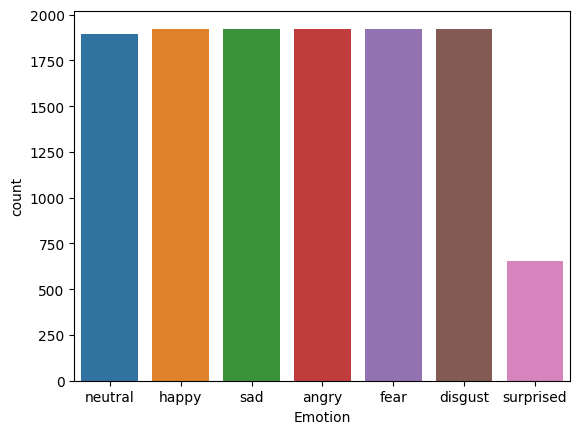

In [49]:
#Exploratory Data Analysis (without calm)

sns.countplot(data = combined_metadata_df, x = 'Emotion')
combined_metadata_df['Emotion'].value_counts()

In [ ]:
#plotting waveform function!

def plot_waveform(waveform,sr,emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion}')
    librosa.display.waveshow(waveform, sr=sr)
    plt.show()

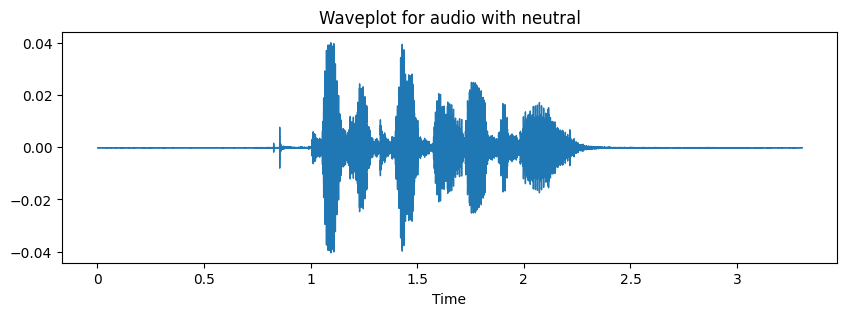

In [59]:
# Surprised was heavily imbalanced so we decided to do augmentations to help balance the dataset...
# We first resampled all the audio files to 24414 hz

#Let's load the resampled audio directory
resampled_dir = os.path.join(os.getcwd(),'Data','Audio_Resampled','Audio_Resampled')

combined_metadata_df['Filepath'] = combined_metadata_df['Filepath'].apply(
    lambda x: os.path.join(resampled_dir, os.path.basename(x))
)

sample_num = 0
test_sample = combined_metadata_df['Filepath'].iloc[sample_num]
emotion = combined_metadata_df['Emotion'].iloc[sample_num]

waveform,sr = torchaudio.load(test_sample)
plot_waveform(waveform=waveform.numpy(),
              sr=sr,
              emotion=emotion)

Audio(waveform,rate = sr)

In [63]:
# Show the augmenations for demonstration purposes
from augmentations import *

#White noise augmentation
def add_white_noise(waveform, 
                    noise_level=np.random.uniform(low =  0.0001,high = 0.001)):
    noise = torch.randn_like(waveform) * noise_level
    print(noise.device)
    return waveform + noise

def time_stretch(waveform, sample_rate, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
    return torch.tensor(stretched).unsqueeze(0)  # Convert back to tensor with channel dimension

def pitch_scale(waveform, sample_rate, 
                n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(low = -1, high = 1)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    pitched = librosa.effects.pitch_shift(waveform_np, sr=sample_rate, n_steps=n_steps)
    return torch.tensor(pitched).unsqueeze(0)  # Convert back to tensor with channel dimension

def polarity_inversion(waveform):
    return -waveform

def apply_gain(waveform, gain_factor = np.random.uniform(low = 5, high = 30)):
    gain = torchaudio.transforms.Vol(gain = gain_factor, gain_type = 'amplitude')
    return gain(waveform)



cpu


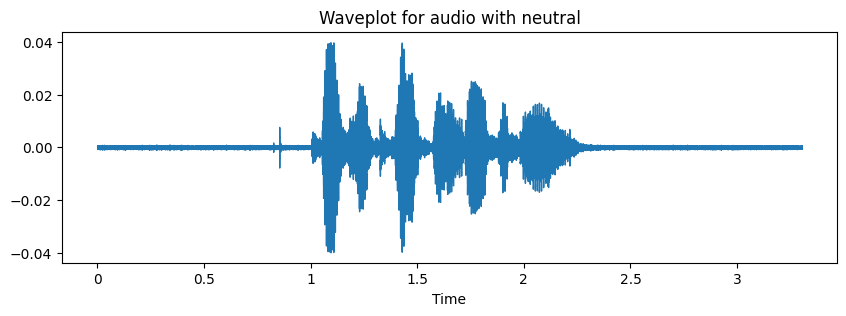

In [66]:

#White noise
waveform_noise = add_white_noise(waveform=waveform.cpu())
plot_waveform(waveform_noise.cpu().numpy(),sr,emotion)
Audio(waveform_noise.cpu(), rate = sr)

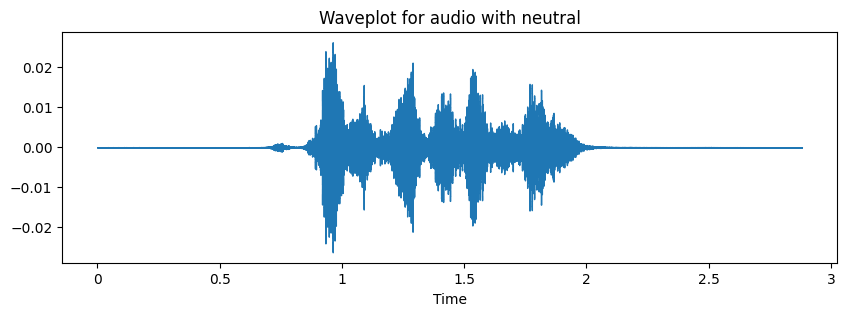

In [69]:
#time stretch
waveform_stretch = time_stretch(waveform=waveform.cpu(),sample_rate=sr)
plot_waveform(waveform_stretch.cpu().numpy(),sr,emotion)
Audio(waveform_stretch.cpu(), rate = sr)

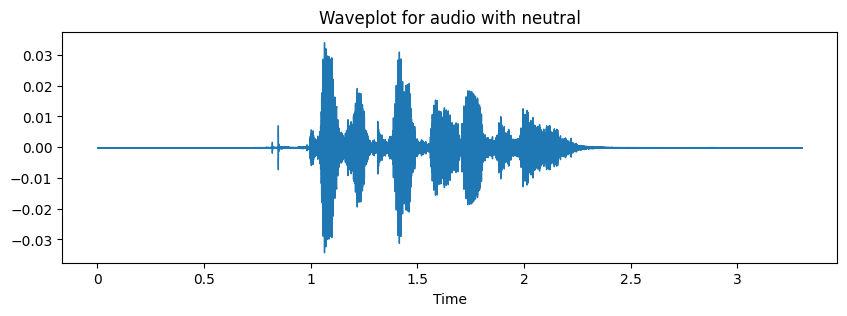

In [70]:
#pitch scale
waveform_pitch = pitch_scale(waveform=waveform.cpu(),sample_rate=sr)
plot_waveform(waveform_pitch.cpu().numpy(),sr,emotion)
Audio(waveform_pitch.cpu(), rate = sr)

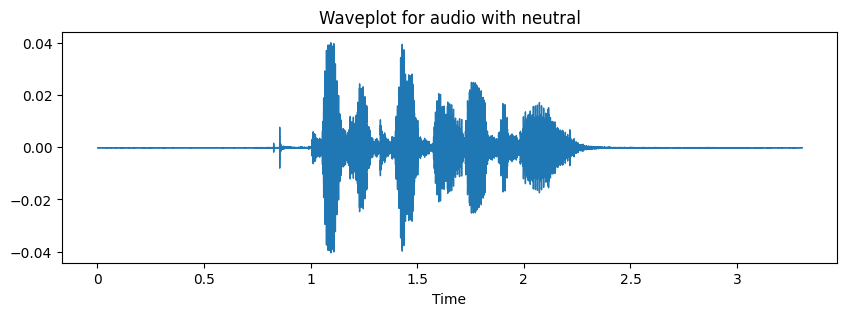

In [71]:
#polarity inversion
waveform_inv = polarity_inversion(waveform=waveform.cpu())
plot_waveform(waveform_inv.cpu().numpy(),sr,emotion)
Audio(waveform_inv.cpu(), rate = sr)

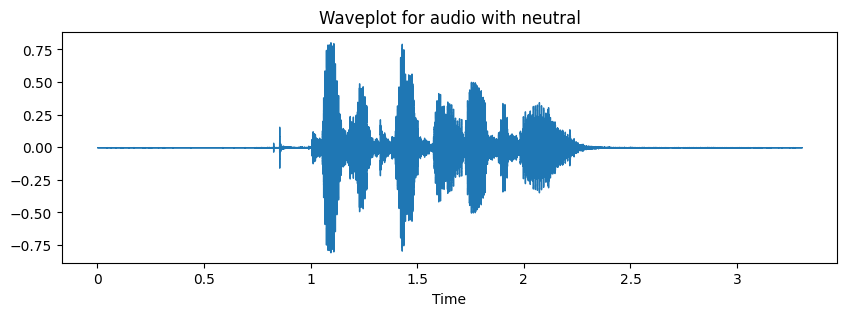

In [73]:
#Gain
waveform_gain = apply_gain(waveform=waveform.cpu(),gain_factor=20)
plot_waveform(waveform_gain.cpu().numpy(),sr,emotion)
Audio(waveform_gain.cpu(), rate = sr)

Waveform shape: torch.Size([1, 80647])
Sampling rate: 24414
cuda:0


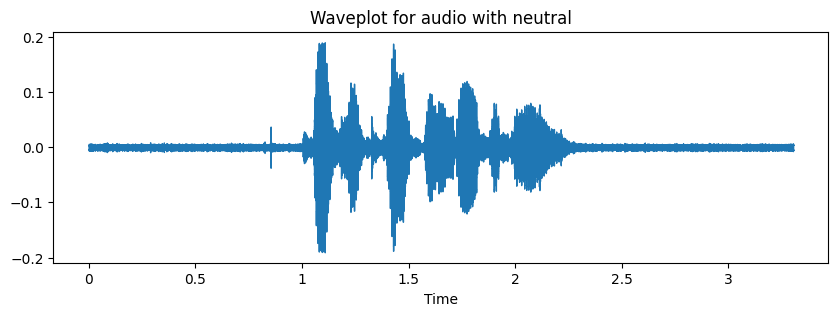

In [77]:
#RANDOM AUGMENTATIONS COMBINED!

waveform= waveform.to(device)
# Verify the waveform and sampling rate
print(f"Waveform shape: {waveform.shape}")
print(f"Sampling rate: {sr}")

# Apply augmentations
augmented_waveform = apply_augmentations(waveform, sample_rate=sr)
plot_waveform(augmented_waveform.cpu().numpy(),sr=sr,emotion=emotion)
Audio(augmented_waveform.cpu(),rate = sr)